Populating the interactive namespace from numpy and matplotlib
In total  465 cosmologies
Count #-par 
	 2097152 
expect 
	 2097152


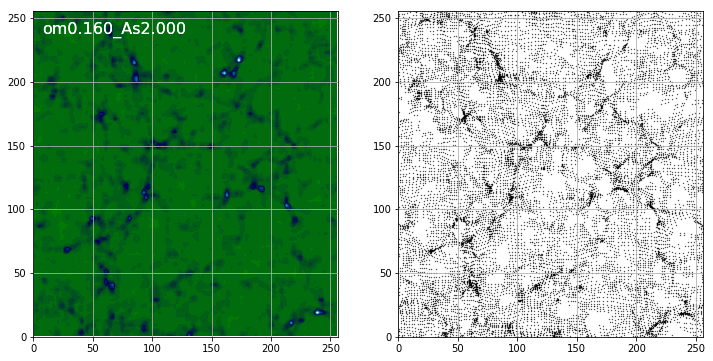

Epoch 1/10
 3/15 [=====>........................] - ETA: 2:55 - loss: 0.1071 - mean_squared_error: 0.1071

KeyboardInterrupt: 

In [25]:
%pylab inline
import numpy as np
import keras, os, pynbody, struct

# lsstr = "ls /media/xiaodongli/0B9ADFB4341AD2BD/om_As/"


lsstr = "ls /media/minstrel/Seagate/cola_multiverse/om_As/"
# 初始化数据集,因函数定义中参数不可转为全局变量
# 此过程受train_test_split的test_size参数的影响,则今后更改或维护程序应注意
test_size = 0.3
batch_size = 31
x_train = np.zeros((batch_size-int(test_size*batch_size)-1, 2))  # 因test_size=0.3,保证初始化矩阵的形状与后面的相同
x_test = np.zeros((int(test_size*batch_size)+1,32,32,32, 1))
y_test = np.zeros((int(test_size*batch_size)+1, 2))
y_train = np.zeros((batch_size-int(test_size*batch_size)-1, 2))

def train_generator():  # 必须无限循环yield数据,全部数据遍历后再重新遍历数据,为下一个epoch yield 数据
    i = 0
    while 1:
        X = []
        y = []
        global x_train, x_test, y_test, y_train, test_size, batch_size
        for cosmology in cosmologies[batch_size * i: batch_size * (i + 1)]:
            X.append(load_grid(cosmology, 'c')[0:32, 0:32, 0:32])
            y.append(np.array([infos[cosmology]['om'], infos[cosmology]['sigma8']]))
        X = np.array(X)
        y = np.array(y)
        x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size)
        x_train = x_train.reshape(-1, 32, 32, 32, 1)
        x_test = x_test.reshape(-1, 32, 32, 32, 1)
        i += 1
        yield x_train, y_train  # tuple 类型
        # 15个批次后重新遍历数据,此循环即死循环
        if i == 465//batch_size:
            i = 0


def mocklist():
    files = os.popen(lsstr + "om*.lua").read().split('\n')
    # *代替多个字母,即列出所有符合条件的.lua文件:om...
    cosmologies = []  # 宇宙学参数
    mocks = {}  # 模拟测试
    ifile = 0  # 有效文件
    for nowfile in files:
        # str[a:b]不存在时,返回'',不存在则忽略
        nowstr = nowfile[-39:-10]
        if nowstr == '':
            continue
        cosmologies.append(nowstr[0:15])
        ifile += 1
        try:
            mocks[nowstr[0:15]] = {'om': float(nowstr[2:7]), 'As': float(nowstr[10:15]),
                                   'sigma8': float(nowstr[23:29])}
            # 添加随机数种子
            ranseed = float(open(nowfile, 'r').readline().split()[2])  # 默认以所有空字符为分隔符,包括空格,\n,\t
            mocks[nowstr[0:15]]['ranseed'] = int(ranseed)
            # print(ranseed)
        except:
            pass
    return cosmologies, files, mocks


def cosmostr(om, As):
    return 'om%.3f' % om + '_As%.3f' % As


def snpfiles(cosmology, snpstr='c'):  #
    return os.popen(lsstr + cosmology + "*snap*" + snpstr + ".*").read().split()


def gridfiles(cosmology, snpstr='c'):
    return os.popen(lsstr + cosmology + "*grid*" + snpstr + ".*").read().split()


def load_grid(gridfile, snpstr='c', printinfo=False):  # 网格加载
    gridfile = os.popen(lsstr + "om%.3f" % om + "_As2.000_sigma8_*grid*" + snpstr + ".*").read().split()[0]
    nowf = open(gridfile, 'rb')  # 以二进制形式读取文件
    # struct:对python基本类型值与用python字符串格式表示的C struct类型间转化
    size = struct.unpack('f' * 1, nowf.read(4 * 1))[0]
    grid_nc = struct.unpack('i' * 1, nowf.read(4 * 1))[0]
    data = struct.unpack('f' * grid_nc ** 3, nowf.read(4 * grid_nc ** 3))
    if printinfo:
        print('read in box size     \n\t', size)
        print('read in num_grid      \n\t', grid_nc)
        print('read in coarse grid \n\tsize    : ', len(data), '\n\texpect  : ', grid_nc ** 3)

    nowf.close()
    return np.array(data).reshape((grid_nc, grid_nc, grid_nc))


cosmologies, filenames, infos = mocklist()
print('In total ', len(cosmologies), 'cosmologies')
cosmology = cosmologies[0]
# print(snpfiles(cosmology))
# print(cosmology)
# pynbody:running a standard series of analysis routines
# print(snpfiles(cosmology))
print('Count #-par \n\t', sum([len(pynbody.load(snpfile)['pos']) for snpfile in snpfiles(cosmology)]),
      '\nexpect \n\t', 128 ** 3)
size = 256

for om in [0.16]:
    fig, (ax1, ax2) = subplots(1, 2, figsize=(12, 6))
    cosmology = cosmostr(om, 2.0)

    # plot grid
    data = load_grid(cosmology, 'c')
    ax1.contourf(np.linspace(1, 255, 128), np.linspace(1, 255, 128), data[:, :, 0].T, 30, cmap='ocean')

    # plot snp
    pos = []
    for snpfile in snpfiles(cosmology, 'c'):
        data = pynbody.load(snpfile)['pos']
        pos.append(np.copy(data[where(data[:, 2] < 2.)]))
    pos = np.concatenate(pos)

    ax2.scatter(pos[:, 0], pos[:, 1], s=0.1, c='k', alpha=1)
    for ax in [ax1, ax2]:
        ax.grid()
        ax.set_xlim(0, size)
        ax.set_ylim(0, size)
        ax1.text(size * 0.03, size * 0.93, cosmology, fontsize=16, color='white')
    plt.show()

from keras import Sequential, layers
from sklearn import model_selection, metrics

model = keras.Sequential([
    layers.Conv3D(32, (3, 3, 3), activation='relu', input_shape=(32, 32, 32, 1)),
    layers.MaxPool3D(pool_size=(2, 2, 2)),
    layers.Conv3D(64, (3, 3, 3), activation='relu'),
    layers.MaxPool3D(pool_size=(2, 2, 2)),
    layers.Conv3D(128, (3, 3, 3), activation='relu'),
    layers.MaxPool3D(pool_size=(2, 2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(2, activation='softmax'),
])
model.compile(optimizer=keras.optimizers.Adadelta(), loss='mean_squared_error',
              metrics=['mean_squared_error'])



# *************************************************************************************************
model.fit_generator(train_generator(),
                    steps_per_epoch=465//batch_size,  # 数据规格可能大小不对应
                    epochs=10,
                    verbose=1,
                    validation_data=(x_test,y_test))
model.predict(x_test)


In [3]:
model.predict(x_test)

array([[0.29936746, 0.7006326 ],
       [0.29936746, 0.7006326 ],
       [0.29936746, 0.7006326 ],
       [0.29936746, 0.7006326 ],
       [0.29936746, 0.7006326 ],
       [0.29936746, 0.7006326 ],
       [0.29936746, 0.7006326 ],
       [0.29936746, 0.7006326 ],
       [0.29936743, 0.7006326 ]], dtype=float32)

NameError: name 'y_test' is not defined